1. load the dataset

In [1]:
import boto3
import pandas as pd

bucket = "ai-bmi-predictor"
key = "data/eff_training.csv"

s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket, Key=key)

data = pd.read_csv(obj["Body"])

data.head()


,photo_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist,gender,height_cm,weight_kg
0,6ab1d061f51c6079633aeceed2faeb0b,0.000068,0.108145,-0.138813,0.633156,0.346266,-0.046055,0.016021,-0.058632,0.097968,...,105.333900,76.817467,35.362858,65.993683,54.459591,88.813789,16.764332,female,170.50,72.0
1,e94e2e05fb8b099955bbc4fa5ce81e22,0.020843,0.026005,-0.093442,0.736929,0.240569,0.089982,-0.112391,0.000435,-0.076110,...,101.478989,85.154358,37.256760,65.861588,52.773052,89.176338,15.690955,male,178.30,71.8
2,ba6951a4f37fc9302243370e927a02e2,0.014542,-0.071332,-0.154407,0.577781,0.196485,-0.125341,-0.056713,-0.027295,0.094879,...,97.488243,81.410393,37.503147,66.042679,57.059261,82.201988,16.686253,male,176.25,76.5
3,947d16539d4702427aa74f737329ffb9,0.041775,0.075746,-0.128497,0.485010,0.120409,0.011227,0.017852,-0.089796,-0.011273,...,120.586845,69.361534,34.084633,60.413330,65.000000,102.323845,17.693762,female,152.10,88.9
4,9326695bf62926ec22690f576a633bba,0.004397,0.058590,-0.154224,0.528140,0.290956,-0.108486,-0.021441,-0.099909,0.080770,...,110.543564,77.160583,38.086231,68.400543,57.172279,107.378578,16.594791,male,171.50,88.4


2. data preprocessing

2.1. categorical encoding for 'gender' feature

In [2]:
import pandas as pd                 # import pandas for data handling

data['gender'] = data['gender'].astype('category')  # convert 'gender' values to categorical type
data['gender'] = data['gender'].cat.codes           # replace 'gender' with its numeric category codes

In [3]:
data['gender'].head()

0    0
1    1
2    1
3    0
4    1
Name: gender, dtype: int8

In [4]:
#data['height_cm'].head()

2.2. define weight frequencies for class imbalance issue for weight_kg

In [5]:
import pandas as pd                     # import pandas for data handling
import numpy as np                      # import numpy to help with safe division

# Assume 'data' is your DataFrame and already loaded
#print("Preview of data:\n", data.head())  # print first few rows to check data
print("\nTotal samples in dataset:", len(data))  # print total number of rows

# -----------------------------
# 1. Create boolean masks for the three weight_kg classes
# -----------------------------
class_1_mask = data['weight_kg'] < 60                      # True where weight_kg is less than 60
class_2_mask = data['weight_kg'] > 100                     # True where weight_kg is greater than 100
class_3_mask = (data['weight_kg'] >= 60) & (data['weight_kg'] <= 100)  # True where weight is between 60 and 100

# -----------------------------
# 2. Calculate class frequencies (counts)
# -----------------------------
freq_class_1 = class_1_mask.sum()          # number of samples with weight_kg < 60
freq_class_2 = class_2_mask.sum()          # number of samples with weight_kg > 100
freq_class_3 = class_3_mask.sum()          # number of samples with 60 <= weight_kg <= 100

print("\nClass frequencies:")              # header for clarity
print("Class 1 (weight_kg < 60):", freq_class_1)   # print frequency of class 1
print("Class 2 (weight_kg > 100):", freq_class_2)  # print frequency of class 2
print("Class 3 (60 <= weight_kg <= 100):", freq_class_3)  # print frequency of class 3

# -----------------------------
# 3. Number of classes according to the strategy
# -----------------------------
num_classes = 3                             # we defined three classes by the rules above
print("\nNumber of classes:", num_classes)  # print number of classes

# -----------------------------
# 4. Compute inverse-frequency weights for each class
#    Formula: w = total_samples / (num_classes * class_frequency)
# -----------------------------
total_samples = len(data)                   # total number of rows in the dataset

def safe_weight(class_freq):                # helper function to avoid division by zero
    if class_freq == 0:                     # check if a class has zero samples
        return np.nan                       # return NaN if no samples exist for that class
    return total_samples / (num_classes * class_freq)  # apply weighting formula

weight_class_1 = safe_weight(freq_class_1)  # compute weight for class 1
weight_class_2 = safe_weight(freq_class_2)  # compute weight for class 2
weight_class_3 = safe_weight(freq_class_3)  # compute weight for class 3

print("\nClass weights (inverse frequency):")          # header for class weights
print("Weight for Class 1 (weight_kg < 60):", weight_class_1)   # print weight of class 1
print("Weight for Class 2 (weight_kg > 100):", weight_class_2)  # print weight of class 2
print("Weight for Class 3 (60 <= weight_kg <= 100):", weight_class_3)  # print weight of class 3



Total samples in dataset: 6134

Class frequencies:
Class 1 (weight_kg < 60): 1049
Class 2 (weight_kg > 100): 514
Class 3 (60 <= weight_kg <= 100): 4571

Number of classes: 3

Class weights (inverse frequency):
Weight for Class 1 (weight_kg < 60): 1.9491579281855735
Weight for Class 2 (weight_kg > 100): 3.9779507133592737
Weight for Class 3 (60 <= weight_kg <= 100): 0.4473127689054182


2.3. define weight frequencies for class imbalance issue for gender feature

In [6]:
import numpy as np                                      # import numpy for numeric utilities (like NaN)

print("Preview of gender column:\n", data['gender'].head())  # show first few gender values to inspect

# -----------------------------------
# 1. Calculate class frequencies for gender
# -----------------------------------
gender_counts = data['gender'].value_counts()           # count how many samples belong to each gender class

print("\nClass frequencies for gender:")                # header for class frequency output
for gender_class, freq in gender_counts.items():        # loop over each gender class and its frequency
    print(f"Class {gender_class}: {freq}")              # print the class label and its frequency

# -----------------------------------
# 2. Number of gender classes
# -----------------------------------
num_gender_classes = len(gender_counts)                 # compute how many distinct gender classes we have
print("\nNumber of gender classes:", num_gender_classes)  # print number of gender classes

# -----------------------------------
# 3. Compute inverse-frequency weights for each gender class
#    Formula: w = total_samples / (num_classes * class_frequency)
# -----------------------------------
total_samples = len(data)                               # total number of samples in the dataset

def safe_weight(class_freq):                            # define helper function to compute class weight safely
    if class_freq == 0:                                 # check for zero frequency to avoid division by zero
        return np.nan                                   # return NaN if a class somehow has zero samples
    return total_samples / (num_gender_classes * class_freq)  # apply the inverse-frequency weight formula

gender_weights = {}                                     # create an empty dictionary to store weights per class
for gender_class, freq in gender_counts.items():        # loop through each gender class and its frequency
    gender_weights[gender_class] = safe_weight(freq)    # compute and store the weight for this gender class

print("\nClass weights (inverse frequency) for gender:")  # header for weight output
for gender_class, weight in gender_weights.items():     # loop over each class and its weight
    print(f"Weight for class {gender_class}: {weight}") # print the computed weight for this gender class


Preview of gender column:
 0    0
1    1
2    1
3    0
4    1
Name: gender, dtype: int8

Class frequencies for gender:
Class 1: 3650
Class 0: 2484

Number of gender classes: 2

Class weights (inverse frequency) for gender:
Weight for class 1: 0.8402739726027397
Weight for class 0: 1.2347020933977455


2.4. weight frequencies for weight classes and gender classes

In [7]:
import numpy as np   # import numpy for numeric operations

# -------------------------------------------------
# 1. Store the already-computed weights for weight classes
#    (use the variables you created when handling weight_kg)
# -------------------------------------------------
weight_class_weights = {                          # dictionary to hold weight-class weights
    'weight_<60':  weight_class_1,                # weight for class: weight_kg < 60
    'weight_>100': weight_class_2,                # weight for class: weight_kg > 100
    'weight_60_100': weight_class_3               # weight for class: 60 <= weight_kg <= 100
}

print("Weight-class weights:", weight_class_weights)  # print weight-class weights to check

# gender_weights dict is assumed from previous step, e.g. {0: w0, 1: w1}
print("Gender-class weights:", gender_weights)        # print gender-class weights to check

# -------------------------------------------------
# 2. Multiply each gender class with each weight class
#    wi = w_weight * w_gender
# -------------------------------------------------
combined_weights = {}                                # dictionary to store combined class weights

print("\nCombined weights for each (weight_class, gender_class):")  # header
for w_label, w_w in weight_class_weights.items():    # loop over weight classes
    for g_label, w_g in gender_weights.items():      # loop over gender classes
        wi = w_w * w_g                               # multiply weight and gender class weights
        combined_weights[(w_label, g_label)] = wi    # store in dictionary
        print(f"{w_label} & gender {g_label}: {wi}") # print each combination

Weight-class weights: {'weight_<60': 1.9491579281855735, 'weight_>100': 3.9779507133592737, 'weight_60_100': 0.4473127689054182}
Gender-class weights: {1: 0.8402739726027397, 0: 1.2347020933977455}

Combined weights for each (weight_class, gender_class):
weight_<60 & gender 1: 1.6378266755466175
weight_<60 & gender 0: 2.4066293742935403
weight_>100 & gender 1: 3.3425684487322993
weight_>100 & gender 0: 4.9115840732177505
weight_60_100 & gender 1: 0.37586527732408703
weight_60_100 & gender 0: 0.5522980121710618


2.5. create a dictionary for weights and row index

In [8]:
# Check current columns in the DataFrame
print("Columns before adding index column:\n", data.columns)

# Add a new column named 'index' with values from 0 to number_of_rows-1
data['index'] = range(len(data))

# Move 'index' to the front (optional, just for nicer viewing)
cols = ['index'] + [c for c in data.columns if c != 'index']  # build new column order
data = data[cols]                                            # reorder columns

# Show first few rows to verify the new indexing column
#print("\nDataFrame after adding 'index' column:\n", data.head())


Columns before adding index column:
 Index(['photo_id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh',
       'waist', 'wrist', 'gender', 'height_cm', 'weight_kg'],
      dtype='object', length=5138)


In [9]:
import numpy as np               # import numpy for numeric operations
import pickle                    # import pickle to save Python objects

# -------------------------------------------------
# 0. We assume these already exist:
#    - weight_class_1, weight_class_2, weight_class_3
#    - gender_weights   (dict: {gender_class: weight})
# -------------------------------------------------

# create a dictionary of weight-class weights (same as before)
weight_class_weights = {         # dictionary mapping weight class labels to their weights
    'weight_<60':  weight_class_1,      # weight for class: weight_kg < 60
    'weight_>100': weight_class_2,      # weight for class: weight_kg > 100
    'weight_60_100': weight_class_3     # weight for class: 60 <= weight_kg <= 100
}

print("Weight-class weights:", weight_class_weights)  # print weight-class weights
print("Gender-class weights:", gender_weights)        # print gender-class weights

# -------------------------------------------------
# 1. Helper function to get the weight class label for a given weight_kg
# -------------------------------------------------
def get_weight_class(w):         # define a function that receives a single weight value
    if w < 60:                   # check if weight is less than 60
        return 'weight_<60'      # return label for class 1
    elif w > 100:                # check if weight is greater than 100
        return 'weight_>100'     # return label for class 2
    else:                        # otherwise weight is between 60 and 100 (inclusive)
        return 'weight_60_100'   # return label for class 3

# -------------------------------------------------
# 2. Build dictionary: keys = index values, values = combined weights
# -------------------------------------------------
final_weights = {}               # create empty dictionary to store final weights

print("\nBuilding final_weights dictionary...")  # message to track progress

for _, row in data.iterrows():   # loop over each row of the DataFrame
    idx_val = row['index']       # get the value from the 'index' column for this row
    gender_val = row['gender']   # get the gender class value for this row
    weight_val = row['weight_kg']# get the weight_kg value for this row

    w_class = get_weight_class(weight_val)        # determine weight class label from weight_kg
    w_weight = weight_class_weights[w_class]      # look up the weight-class weight
    w_gender = gender_weights[gender_val]         # look up the gender-class weight

    combined_w = w_weight * w_gender             # multiply to get combined weight w_i
    final_weights[idx_val] = combined_w          # store combined weight in dictionary with key=index

print("Number of entries in final_weights:", len(final_weights))  # print number of entries
print("First 5 items in final_weights:", list(final_weights.items())[:5])  # show first few items

# -------------------------------------------------
# 3. Check index 0: gender, weight_kg, and combined weight
# -------------------------------------------------
print("\nChecking entry with index 0...")        # message to show what we're doing

row0 = data.loc[data['index'] == 0].iloc[0]      # select the row where 'index' column equals 0

gender0 = row0['gender']                         # get gender value for index 0
weight0 = row0['weight_kg']                      # get weight_kg value for index 0
w_class0 = get_weight_class(weight0)             # get weight class label for index 0

w_weight0 = weight_class_weights[w_class0]       # get weight-class weight for index 0
w_gender0 = gender_weights[gender0]              # get gender-class weight for index 0
combined0_calc = w_weight0 * w_gender0           # calculate combined weight for index 0

print("Row 0 -> gender:", gender0)               # print gender class for index 0
print("Row 0 -> weight_kg:", weight0)            # print weight_kg for index 0
print("Row 0 -> weight class:", w_class0)        # print weight class label for index 0
print("w_weight for row 0:", w_weight0)          # print weight-class weight for index 0
print("w_gender for row 0:", w_gender0)          # print gender-class weight for index 0
print("Combined weight (calculated):", combined0_calc)        # print calculated combined weight
print("Combined weight from final_weights[0]:", final_weights[0])  # print value from dictionary

# -------------------------------------------------
# 4. Save final_weights dictionary as a pickle file
# -------------------------------------------------
print("\nSaving final_weights dictionary as pickle file...")   # message to track saving step

with open('final_weights.pkl', 'wb') as f:       # open a file named 'final_weights.pkl' in binary write mode
    pickle.dump(final_weights, f)                # write dictionary to the file using pickle

print("Dictionary saved to 'final_weights.pkl'.")# confirmation message


Weight-class weights: {'weight_<60': 1.9491579281855735, 'weight_>100': 3.9779507133592737, 'weight_60_100': 0.4473127689054182}
Gender-class weights: {1: 0.8402739726027397, 0: 1.2347020933977455}

Building final_weights dictionary...
Number of entries in final_weights: 6134
First 5 items in final_weights: [(0, 0.5522980121710618), (1, 0.37586527732408703), (2, 0.37586527732408703), (3, 0.5522980121710618), (4, 0.37586527732408703)]

Checking entry with index 0...
Row 0 -> gender: 0
Row 0 -> weight_kg: 72.0
Row 0 -> weight class: weight_60_100
w_weight for row 0: 0.4473127689054182
w_gender for row 0: 1.2347020933977455
Combined weight (calculated): 0.5522980121710618
Combined weight from final_weights[0]: 0.5522980121710618

Saving final_weights dictionary as pickle file...
Dictionary saved to 'final_weights.pkl'.


2.6. apply min-max scaling with range -1 to 1 for body measurements

In [10]:
from sklearn.preprocessing import MinMaxScaler   # import the scaler for min-max normalization

# list of columns to scale between -1 and 1
cols_to_scale = [
    'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip',
    'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh',
    'waist', 'wrist', 'height_cm', 'weight_kg'
]

scaler = MinMaxScaler(feature_range=(-1, 1))    # create a scaler that maps values to range [-1, 1]

data[cols_to_scale] = scaler.fit_transform(     # fit the scaler and transform the selected columns
    data[cols_to_scale]
)

3. model training

3.1. split the data for independent and dependent features

In [11]:
# List of columns to be used as dependent (target) features
target_cols = [
    'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip',
    'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh',
    'waist', 'wrist', 'weight_kg'
]

# Select these columns from the DataFrame as the multi-target Y
Y = data[target_cols]                  # Y will hold all dependent variables for multi-target regression

print("Selected target columns:", target_cols)  # print which columns are used as targets
print("Shape of Y (samples, targets):", Y.shape)  # print shape to confirm dimensions

Selected target columns: ['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist', 'weight_kg']
Shape of Y (samples, targets): (6134, 14)


In [12]:
# Columns to drop for building independent features (X)
drop_cols = ['photo_id', 'subject_id','index'] + target_cols   # combine ID columns with target columns

print("Columns to drop for X:\n", drop_cols)           # show which columns will be removed

# Create X by dropping ID columns and all target columns
X = data.drop(columns=drop_cols)                       # drop the unwanted columns to get independent features

print("\nShape of X (samples, independent features):", X.shape)  # print shape of X
#print("\nColumns in X:\n", X.columns.tolist())         # list all feature names in X

Columns to drop for X:
 ['photo_id', 'subject_id', 'index', 'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist', 'weight_kg']

Shape of X (samples, independent features): (6134, 5122)


In [13]:
# -----------------------------
# Imports
# -----------------------------
import numpy as np                          # numerical operations
import pickle                               # to load the final_weights.pkl file
import matplotlib.pyplot as plt             # for plotting loss curves

from sklearn.model_selection import train_test_split  # to create train/validation sets

import tensorflow as tf                     # main deep learning library
from tensorflow.keras.models import Sequential          # model container
from tensorflow.keras.layers import Dense, Dropout, InputLayer, LeakyReLU, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

# -----------------------------
# Reproducibility (optional)
# -----------------------------
np.random.seed(42)                          # fix numpy random seed
tf.random.set_seed(42)                      # fix tensorflow random seed

# -----------------------------
# 1. Assume you already have:
#    - data DataFrame
#    - X (independent features)
#    - Y (multi-output targets)
# If not, you can recreate X, Y here.
# -----------------------------

# Example (uncomment if you want everything in one place):
# target_cols = [
#     'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip',
#     'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh',
#     'waist', 'wrist', 'weight_kg'
# ]
# Y = data[target_cols]                                            # select target columns
# drop_cols = ['photo_id', 'subject_id'] + target_cols             # columns not used as features
# X = data.drop(columns=drop_cols + ['index'])                     # drop also 'index' from features

print("Shape of X (features):", X.shape)           # show shape of feature matrix
print("Shape of Y (targets):", Y.shape)           # show shape of target matrix

# -----------------------------
# 2. Load final_weights.pkl (sample weights per index)
# -----------------------------
print("\nLoading final_weights.pkl ...")          # status message

with open('final_weights.pkl', 'rb') as f:        # open pickle file in read-binary mode
    final_weights_dict = pickle.load(f)           # load dictionary {index: weight}

print("Number of entries in final_weights_dict:", len(final_weights_dict))  # size of dictionary
print("First 5 entries in final_weights_dict:", list(final_weights_dict.items())[:5])  # preview


2025-11-28 12:02:10.561284: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 12:02:10.575198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-28 12:02:10.595498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-28 12:02:10.595539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-28 12:02:10.608297: I tensorflow/core/platform/cpu_feature_gua

Shape of X (features): (6134, 5122)
Shape of Y (targets): (6134, 14)

Loading final_weights.pkl ...
Number of entries in final_weights_dict: 6134
First 5 entries in final_weights_dict: [(0, 0.5522980121710618), (1, 0.37586527732408703), (2, 0.37586527732408703), (3, 0.5522980121710618), (4, 0.37586527732408703)]


In [14]:
# -----------------------------
# 3. Build sample_weight array based on DataFrame 'index' column
# -----------------------------
print("\nBuilding sample_weight array ...")       # status message

# map each row's 'index' value to its weight in the dictionary
sample_weights = data['index'].map(final_weights_dict).values.astype('float32')

print("Sample weights shape:", sample_weights.shape)   # show shape of weight array
print("First 10 sample weights:", sample_weights[:10]) # preview some weights


Building sample_weight array ...
Sample weights shape: (6134,)
First 10 sample weights: [0.552298   0.37586528 0.37586528 0.552298   0.37586528 0.552298
 0.37586528 0.37586528 0.552298   0.37586528]


In [15]:
# -----------------------------
# 4. Train/validation split (X, Y, and weights)
# -----------------------------
print("\nSplitting into train and validation sets ...")  # status message

X_train, X_val, Y_train, Y_val, w_train, w_val = train_test_split(
    X, Y, sample_weights,           # split features, targets, and weights together
    test_size=0.2,                  # 20% validation
    random_state=42,                # reproducible split
    shuffle=True                    # shuffle data before splitting
)

print("X_train shape:", X_train.shape)          # show training feature shape
print("Y_train shape:", Y_train.shape)          # show training target shape
print("X_val shape:", X_val.shape)              # show validation feature shape
print("Y_val shape:", Y_val.shape)              # show validation target shape


Splitting into train and validation sets ...
X_train shape: (4907, 5122)
Y_train shape: (4907, 14)
X_val shape: (1227, 5122)
Y_val shape: (1227, 14)



Total hyper-parameter combinations: 1

Training combination 1/1
Hidden layers: 3
Neurons per layer: 64
Activation: gelu
Learning rate: 0.0001
Optimizer: adam


2025-11-28 12:02:12.474175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-28 12:02:12.521629: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-28 12:02:12.524399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/300


I0000 00:00:1764331347.631576   16436 service.cc:145] XLA service 0x7fefa45ec420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764331347.631615   16436 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-11-28 12:02:27.638355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-28 12:02:27.657369: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1764331347.714260   16436 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 16s 37ms/step - loss: 0.2558 - mse: 0.2497 - val_loss: 0.2370 - val_mse: 0.2236 - lr: 1.0000e-04
Epoch 2/300
25/25 [==============================] - 0s 8ms/step - loss: 0.2231 - mse: 0.2178 - val_loss: 0.1886 - val_mse: 0.1780 - lr: 1.0000e-04
Epoch 3/300
25/25 [==============================] - 0s 7ms/step - loss: 0.1887 - mse: 0.1843 - val_loss: 0.1512 - val_mse: 0.1426 - lr: 1.0000e-04
Epoch 4/300
25/25 [==============================] - 0s 7ms/step - loss: 0.1622 - mse: 0.1584 - val_loss: 0.1193 - val_mse: 0.1125 - lr: 1.0000e-04
Epoch 5/300
25/25 [==============================] - 0s 8ms/step - loss: 0.1465 - mse: 0.1430 - val_loss: 0.1104 - val_mse: 0.1042 - lr: 1.0000e-04
Epoch 6/300
25/25 [==============================] - 0s 7ms/step - loss: 0.1330 - mse: 0.1299 - val_loss: 0.0972 - val_mse: 0.0917 - lr: 1.0000e-04
Epoch 7/300
25/25 [==============================] - 0s 7ms/step - loss: 0.1236 - mse: 0.1206 - val_loss: 0.0911 - val_mse

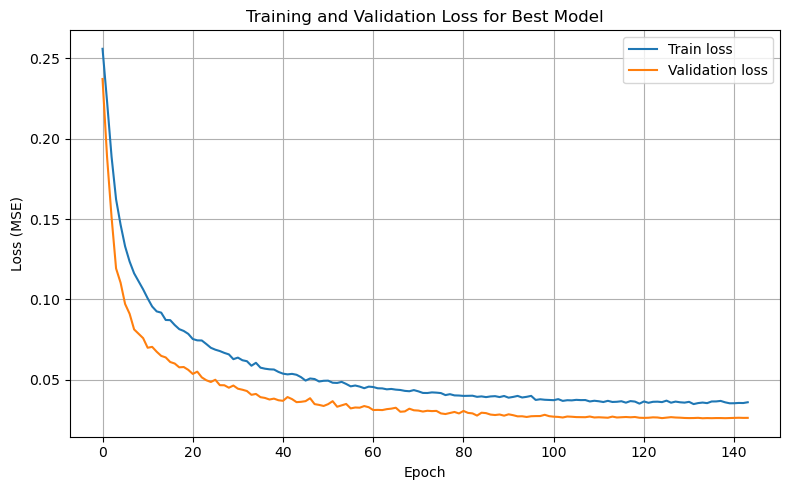


Saving best model to 'eff_best.h5' ...
Model saved as 'eff_best.h5'. Done!


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# -----------------------------
# 5. Helper: build model function
# -----------------------------
def build_model(num_hidden_layers, num_neurons, activation_name,
                learning_rate, optimizer_name, input_dim, output_dim,
                dropout_rate=0.3):
    """
    Build and compile a Keras Sequential model
    for multi-output regression.
    """

    model = Sequential()                              # create empty sequential model

    model.add(InputLayer(input_shape=(input_dim,)))   # add input layer with correct feature size

    for _ in range(num_hidden_layers):                # loop over number of hidden layers
        model.add(Dense(num_neurons))                 # add dense layer with given number of neurons

        # choose activation depending on activation_name
        if activation_name.lower() == 'leakyrelu':    # check if activation is LeakyReLU
            model.add(LeakyReLU(alpha=0.1))           # add LeakyReLU activation layer
        elif activation_name.lower() == 'gelu':       # check if activation is GELU
            model.add(Activation(tf.keras.activations.gelu))  # add GELU activation layer
        elif activation_name.lower() == 'tanh':       # check if activation is tanh
            model.add(Activation('tanh'))             # add tanh activation layer
        else:                                         # if activation name is unknown
            raise ValueError("Unknown activation: {}".format(activation_name))  # raise error

        model.add(Dropout(dropout_rate))              # add dropout layer for regularization

    model.add(Dense(output_dim, activation='linear')) # add output layer (linear for regression)

    # choose optimizer based on name
    if optimizer_name.lower() == 'sgd':               # if optimizer is SGD
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)  # create SGD with momentum
    elif optimizer_name.lower() == 'adam':            # if optimizer is Adam
        optimizer = Adam(learning_rate=learning_rate) # create Adam optimizer
    elif optimizer_name.lower() == 'rmsprop':         # if optimizer is RMSprop
        optimizer = RMSprop(learning_rate=learning_rate)  # create RMSprop optimizer
    else:                                             # if optimizer name is unknown
        raise ValueError("Unknown optimizer: {}".format(optimizer_name))  # raise error

    # compile the model
    model.compile(
        optimizer=optimizer,          # set chosen optimizer
        loss='mse',                   # use mean squared error as base loss (will use sample_weight)
        metrics=[],                   # no unweighted metrics
        weighted_metrics=[            # metrics that MUST use sample_weight
            tf.keras.metrics.MeanSquaredError(name='mse')  # weighted MSE metric called "mse"
        ]
    )

    return model                      # return compiled model


# -----------------------------
# 6. Define hyper-parameter grid for manual search
# -----------------------------
num_hidden_layers_list = [3]                    # options for number of hidden layers
num_neurons_list = [64]                     # options for neurons per hidden layer
activation_list = ['gelu']       # options for activation functions
learning_rates = [1e-4]                   # options for learning rates
optimizer_list = ['adam']           # options for optimizers

batch_size = 200                                      # batch size for training
num_epochs = 300                                      # maximum number of epochs

# compute total number of hyper-parameter combinations
total_combinations = (len(num_hidden_layers_list) *
                      len(num_neurons_list) *
                      len(activation_list) *
                      len(learning_rates) *
                      len(optimizer_list))

print("\nTotal hyper-parameter combinations:", total_combinations)  # print total number of combos

# -----------------------------
# 7. Grid search loop
# -----------------------------
best_val_loss = np.inf                   # initialize best validation loss with infinity
best_history = None                      # variable to store history of best model
best_params = None                       # variable to store best hyper-parameters
best_model = None                        # variable to store best trained model

combo_counter = 0                        # counter to track which combo we are training

input_dim = X_train.shape[1]             # number of input features
output_dim = Y_train.shape[1]            # number of output targets

# loop over all hyper-parameter combinations
for num_hidden_layers in num_hidden_layers_list:              # loop over hidden layer counts
    for num_neurons in num_neurons_list:                      # loop over neuron counts
        for activation_name in activation_list:               # loop over activations
            for lr in learning_rates:                         # loop over learning rates
                for optimizer_name in optimizer_list:         # loop over optimizers

                    combo_counter += 1                        # increase combination counter

                    print("\n======================================")
                    print(f"Training combination {combo_counter}/{total_combinations}")  # show combo index
                    print(f"Hidden layers: {num_hidden_layers}")                          # print layer count
                    print(f"Neurons per layer: {num_neurons}")                            # print neuron count
                    print(f"Activation: {activation_name}")                                # print activation
                    print(f"Learning rate: {lr}")                                          # print learning rate
                    print(f"Optimizer: {optimizer_name}")                                  # print optimizer
                    print("======================================")

                    # build model with current hyper-parameters
                    model = build_model(num_hidden_layers,
                                         num_neurons,
                                         activation_name,
                                         lr,
                                         optimizer_name,
                                         input_dim,
                                         output_dim)

                    # define early stopping callback
                    early_stop = EarlyStopping(
                        monitor='val_loss',           # watch validation loss
                        patience=10,                  # stop if no improvement for 15 epochs
                        restore_best_weights=True,    # restore weights from best epoch
                        verbose=1                     # print message when stopping
                    )

                    # define learning rate scheduler callback
                    lr_scheduler = ReduceLROnPlateau(
                        monitor='loss',               # watch training loss
                        factor=0.5,                   # reduce learning rate by factor 0.5
                        patience=5,                  # wait 10 epochs before reducing LR
                        min_lr=1e-6,                  # do not go below this LR
                        verbose=1                     # print message when LR changes
                    )

                    callbacks = [early_stop, lr_scheduler]  # list of callbacks to use

                    # train the model with sample weights
                    history = model.fit(
                        X_train,                     # training features
                        Y_train,                     # training targets
                        sample_weight=w_train,       # sample weights for training data
                        validation_data=(X_val, Y_val, w_val),  # validation data + weights
                        epochs=num_epochs,           # maximum number of epochs
                        batch_size=batch_size,       # batch size
                        callbacks=callbacks,         # callbacks list
                        verbose=1                    # show training progress per epoch
                    )

                    # compute minimum validation loss for this model
                    min_val_loss = min(history.history['val_loss'])

                    print(f"Finished combination {combo_counter}. "
                          f"Best val_loss for this model: {min_val_loss:.6f}")  # print best val_loss

                    # check if this model is better than previous best
                    if min_val_loss < best_val_loss:
                        print(">>> New best model found! Updating best model ...")  # notify improvement
                        best_val_loss = min_val_loss          # update best validation loss
                        best_history = history                # save training history
                        best_params = {                       # save best hyper-parameters
                            'num_hidden_layers': num_hidden_layers,
                            'num_neurons': num_neurons,
                            'activation': activation_name,
                            'learning_rate': lr,
                            'optimizer': optimizer_name
                        }
                        best_model = model                    # save best model

# -----------------------------
# 8. Show best hyper-parameter combination
# -----------------------------
print("\n================ BEST MODEL =================")   # header for best model
print("Best validation loss:", best_val_loss)            # print best validation loss
print("Best hyper-parameters:")                          # header for params
for k, v in best_params.items():                         # loop over param dict
    print(f"  {k}: {v}")                                 # print each param
print("=============================================")

# -----------------------------
# 9. Plot loss and val_loss curves for best model
# -----------------------------
print("\nPlotting loss and val_loss curves for the best model ...")  # status message

plt.figure(figsize=(8, 5))                               # create a new figure
plt.plot(best_history.history['loss'], label='Train loss')      # plot training loss
plt.plot(best_history.history['val_loss'], label='Validation loss')  # plot validation loss
plt.xlabel('Epoch')                                     # label x-axis
plt.ylabel('Loss (MSE)')                               # label y-axis
plt.title('Training and Validation Loss for Best Model') # set plot title
plt.legend()                                           # show legend
plt.grid(True)                                         # add grid lines
plt.tight_layout()                                     # adjust layout
plt.show()                                             # display plot

# -----------------------------
# 10. Save the final best model
# -----------------------------
print("\nSaving best model to 'eff_best.h5' ...")       # status message

best_model.save('eff_best.h5')                         # save best model to H5 file

print("Model saved as 'eff_best.h5'. Done!")           # final confirmation message


In [17]:
import boto3                    # AWS SDK for Python
import os                       # to check file paths

# -----------------------------
# 1. Local model file info
# -----------------------------
local_model_path = "eff_best.h5"   # path where you saved the model

# check that the file exists before uploading
if not os.path.exists(local_model_path):
    raise FileNotFoundError(f"Model file not found: {local_model_path}")

print(f"Found model file: {local_model_path}")

# -----------------------------
# 2. S3 bucket and key info
# -----------------------------
bucket_name = "ai-bmi-predictor"  # your S3 bucket name

# S3 key (path inside the bucket)
s3_key = "trained-models/efficientnet-models/eff_ann_version1.h5"

print(f"Model will be uploaded to s3://{bucket_name}/{s3_key}")

# -----------------------------
# 3. Create S3 client
# -----------------------------
# This assumes your AWS credentials are configured (env vars, ~/.aws/credentials, or IAM role)
s3_client = boto3.client("s3")    # create S3 client

# -----------------------------
# 4. Upload the file
# -----------------------------
print("Uploading model to S3 ...")

s3_client.upload_file(
    Filename=local_model_path,    # local file path
    Bucket=bucket_name,           # target S3 bucket
    Key=s3_key                    # target S3 key (including folders and filename)
)

print("Upload completed successfully!")
print(f"File is now at: s3://{bucket_name}/{s3_key}")


Found model file: eff_best.h5
Model will be uploaded to s3://ai-bmi-predictor/trained-models/efficientnet-models/eff_ann_version1.h5
Uploading model to S3 ...
Upload completed successfully!
File is now at: s3://ai-bmi-predictor/trained-models/efficientnet-models/eff_ann_version1.h5
